In [ ]:
#hide
import datetime
import logging
import sys

from fbprophet import Prophet
from loguru import logger
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.core.frame import DataFrame
from pandas._libs.tslibs.timestamps import Timestamp
import seaborn as sns
import statsmodels.stats.api as sms
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tools.tools import add_constant
from statsmodels.tsa.arima.model import ARIMA

import elec_consumption.forecast as forecast
import elec_consumption.utils as utils

Importing plotly failed. Interactive plots will not work.


In [ ]:
#hide
%matplotlib inline
plt.style.use('seaborn')
_golden_ratio = 1.61803398875
plt.rcParams['figure.figsize'] = [6 * _golden_ratio, 6]

logging.disable(sys.maxsize)

data = {
    'zeroHour': None,  # series, hourly power profile of unit 0
    'zeroHourFb': None,  # for Prophet, hourly power profile of unit 0
}  # contain modified dataframes
mod = {
    'zeroDayFb': None,  # for Prophet using daily power profile of unit 0
    'zeroHourFb': None,  # Prophet, using hourly power profile of unit 0
}

# Regression

In [ ]:
#hide
# Import 500 profiles.
df = pd.read_csv('./data/raw.csv', index_col=0)
df.columns = list(range(df.shape[1]))
df.columns.name = 'household'
df.index = pd.to_datetime(df.index)
df.index.name = 'datetime'

## 1. Introduction

To combine multiple series belonging to different units is not a good idea, through there is a simple way to do it ([estimating same model over multiple time series, `crossvalidated`](https://stats.stackexchange.com/a/23123/231405)).

### Why Facebook `Prophet`

[`Prophet`](https://facebook.github.io/prophet/) is an open-source package for modelling and forecasting univariate time series by Facebook. Its model structure is similar to that of generalised additive models (GAM), where distinct non-linear terms are integrated in a linear way. `Prophet` works best when the series shows strong and multiple seasonality, and it is robust to missing values and effect from holidays, making it the perfect choice in our case.

## 2. Demo: Daily Profile of Household 0

Though profiles in the same cluster tend to show similar patterns, it is relatively easy to build different statistical model for different households. Daily profiles of household 0 is modelled by Facebook `Prophet` and seasonal ARIMA in this section.

In [ ]:
#hide
# To pandas time series
data['tsPdDaily'] = df.iloc[:, 0].resample('1D', closed='left').mean()

### Facebook `Prophet`

In [ ]:
#hide
ts_fb = data['tsPdDaily'].to_frame().reset_index()  # to Prophet time series
ts_fb.columns = ['ds', 'y']

In [ ]:
#hide
mod['zeroDayFb'] = Prophet()
mod['zeroDayFb'].fit(ts_fb)

In [ ]:
#hide
df_future = mod['zeroDayFb'].make_future_dataframe(periods=3)
df_forecast = mod['zeroDayFb'].predict(df_future)

Here is resulted Line plot from the model. Point forecasts and confidence intervals are plotted.

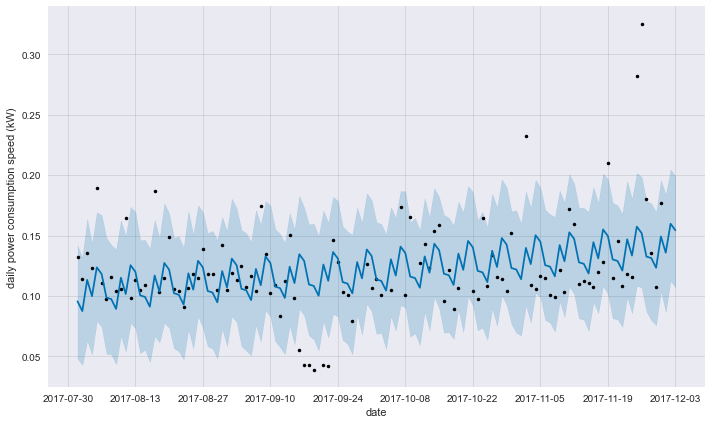

In [ ]:
#hide_input
mod['zeroDayFb'].plot(
    df_forecast, xlabel='date', ylabel='daily power consumption speed (kW)'
);

Forcasts and confidence intervals for future 3 days:

In [ ]:
#hide_input
res = df_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(3)
res['ds'] = res['ds'].apply(lambda x: x.date())
res = res.set_index('ds')
res.index.name = 'date'
res

,yhat,yhat_lower,yhat_upper
date,,,
2017-12-01,0.135803,0.086821,0.183732
2017-12-02,0.159741,0.112539,0.204645
2017-12-03,0.154350,0.107019,0.199003


According to the previous figure, there is a trending and a weekly seasonal components, which are shown in following two figures respectively. The trending component increased from 0.104 to 0.141 in 122 days. That is, the average power consumption increased by 34.93 % in merely 4 months. Such trending effect must be taken into account.

Surprisingly, there are variations in power consumption over one week. Household 0 tends to consume more during weekends and Thursday. The difference between values on Saturday and on Wednesday amounts to 28.98 % of the mean power consumption, so this effect is essential as well.

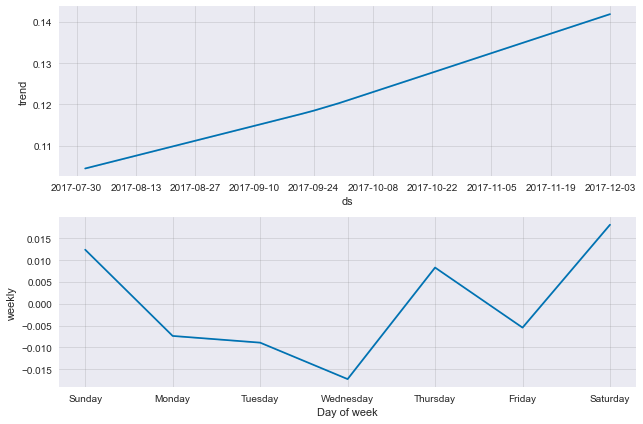

In [ ]:
#hide_input
mod['zeroDayFb'].plot_components(df_forecast);

In [ ]:
#hide
utils.cal_increment_percent(df_forecast['trend'][:122])

(34.932460347034294, 0.14090571916533756, 0.10442685088742959)

In [ ]:
#hide
data['tsPdDaily'].dropna().describe().to_frame()

,0
count,111.000000
mean,0.122169
std,0.040575
min,0.039063
25%,0.104333
50%,0.114188
75%,0.134198
max,0.325417


In [ ]:
#hide
_, _max, _min = utils.cal_increment_percent(df_forecast.head(7)['weekly'][:122])
(_max - _min) / 0.122169 * 100

28.98089486763557

In [ ]:
#hide
### Residual Analysis for Prophet Model

In [ ]:
#hide
data['resDaily'] = df_forecast.loc[:121, ['ds', 'yhat']]
data['resDaily'].set_index('ds', inplace=True)
data['resDaily']['yhat'] = data['resDaily']['yhat'] - data['tsPdDaily']
data['resDaily'].columns = ['resid']
data['resDaily']['resid'].fillna(0, inplace=True)

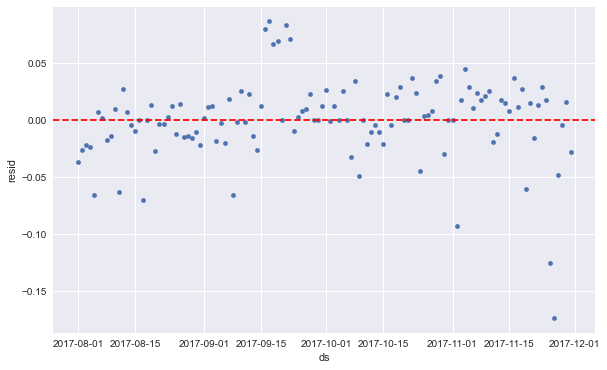

In [ ]:
#hide
_, ax = plt.subplots(1, 1)
data['resDaily'].reset_index().plot.scatter(x='ds', y='resid', ax=ax);
ax.axhline(0, ls='--', color='r');

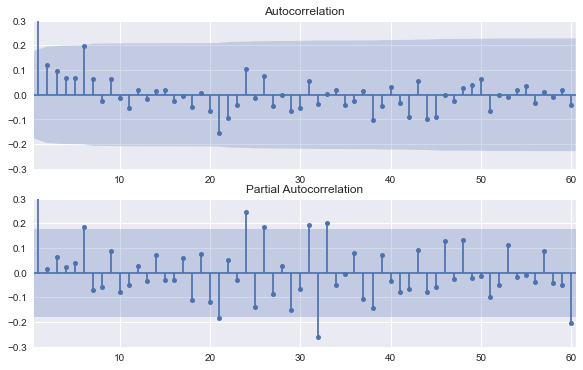

In [ ]:
#hide
utils.plot_acf_pacf(data['resDaily'])

### Seasonal ARIMA

It is impossible to plot ACF and PACF for original series because of missing entries. As discussed before, they are adjacent so it is hard to fill with meaningful values. Previous result provides a starting point. To have a weekly season is a good idea, and it should be "integrated", in order to remove the long-term trend.

For example, an AR1 and weekly seasonal AR1 model can be built. The seasonal AR1 term (value 0.1603, std error 0.145, pvalue 0.269) is a bit controversial, but stays due to the previous finding. The normality and heteroskedasticity assumptions are both rejected, so this is not good model.

In [ ]:
#hide
fit = ARIMA(
    endog=data['tsPdDaily'], order=(1, 1, 1), freq='D', seasonal_order=(1, 0, 0, 7)
).fit()

In [ ]:
#hide
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                                y   No. Observations:                  122
Model:             ARIMA(1, 1, 1)x(1, 0, [], 7)   Log Likelihood                 204.958
Date:                          Fri, 18 Dec 2020   AIC                           -401.915
Time:                                  07:24:28   BIC                           -390.732
Sample:                              08-01-2017   HQIC                          -397.373
                                   - 11-30-2017                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4273      0.096      4.450      0.000       0.239       0.615
ma.L1         -0.9926      0.082    -12.091      0.000      -1.154      -0.832
ar.S.L7        0.1603      0.145      1.105      0.269      -0.124       0.445
sigma2         0.0013      0.000     11.158      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.44   Jarque-Bera (JB):               122.13
Prob(Q):                              0.51   Prob(JB):                         0.00
Heteroskedasticity (H):               2.71   Skew:                             1.49
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Good news is that there is nothing left according to ACF and PACF. This example is actually the final model selected after a manual model selection.

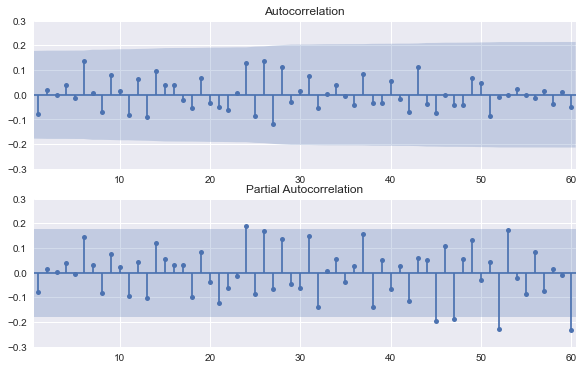

In [ ]:
#hide_input
utils.plot_acf_pacf(fit.resid.fillna(0))

### Pseudo Out-of-Sample Validation

There are systematic ways for validation. It is challenging to conduct a cross validation for time series models, especially when there is long-term trend. Pseudo out-of-sample validation is used instead. Here is a [description from `statsmodels`](https://www.statsmodels.org/stable/examples/notebooks/generated/statespace_forecasting.html#Cross-validation):

"A common use case is to cross-validate forecasting methods by performing h-step-ahead forecasts recursively using the following process"

- Fit model parameters on a training sample
- Produce h-step-ahead forecasts from the end of that sample
- Compare forecasts against test dataset to compute error rate
- Expand the sample to include the next observation, and repeat

MSE of 3-step forecast using Facebook Prophet is 0.00356, and its root is 48.83 % of mean power consumption. So this is not a good model.

In [ ]:
#hide
frames = []
for i in range(97, 119):
    frames.append(
        forecast.validate(forecast.fit_prophet, data['tsPdDaily'], i)
    )

In [ ]:
#hide
# Result is 0.003558756357791278.
res = pd.concat(frames)
mse = (res['resid']**2).mean()
mse

0.003558756357791278

In [ ]:
#hide
np.sqrt(mse) / 0.122169 * 100

48.830155690053715

MSE of 3-step forecast using seasonal ARIMA is 0.00383, which is 7.736 % higher than MSE using Prophet.

In [ ]:
#hide
frames = []
for i in range(97, 119):
    frames.append(
        forecast.validate(forecast.fit_sarima, data['tsPdDaily'], i)
    )

In [ ]:
#hide
# Result is 0.003834059794252662.
res = pd.concat(frames)
mse = (res['resid']**2).mean()
mse

0.003834059794252662

In [ ]:
#hide
np.sqrt(mse) / 0.122169

0.5068371285672818

## 3. Demo: Hourly Profile of Household 0

`Prophet` can even be used to model time series with hourly (sub-daily) resolution.

In [ ]:
#hide
data['zeroHour'] = df.iloc[:, 0].resample('1H', closed='left').mean()  # to pandas time series
data['zeroHourFb'] = data['zeroHour'].to_frame().reset_index()  # to Prophet time series
data['zeroHourFb'].columns = ['ds', 'y']
mod['zeroHourFb'] = Prophet()
mod['zeroHourFb'].fit(data['zeroHourFb'])

In [ ]:
#hide
df_future = mod['zeroHourFb'].make_future_dataframe(
    periods=24, freq='H', include_history=True
)
df_forecast = mod['zeroHourFb'].predict(df_future)

In [ ]:
#hide
# Store endogenous variables, in-sample predictions, and residuals in one dataframe.
data['zeroHourFbResid'] = df_forecast.loc[
    df_forecast['ds'] < Timestamp('2017-12-01 00:00:00'),
    ['ds', 'yhat']
]
data['zeroHourFbResid'].set_index('ds', inplace=True)
data['zeroHourFbResid'].index.name = 'datetime'
data['zeroHourFbResid']['y'] = data['zeroHour']
data['zeroHourFbResid']['resid'] = data['zeroHourFbResid']['y'] - data['zeroHourFbResid']['yhat']

# Drop rows with NaN.
data['zeroHourFbResidNaN0'] = data['zeroHourFbResid'].dropna()
assert data['zeroHourFbResidNaN0'].shape == (2664, 3)

Here is a line plot for in-sample and out-of-sample forecasts and confidence intervals.

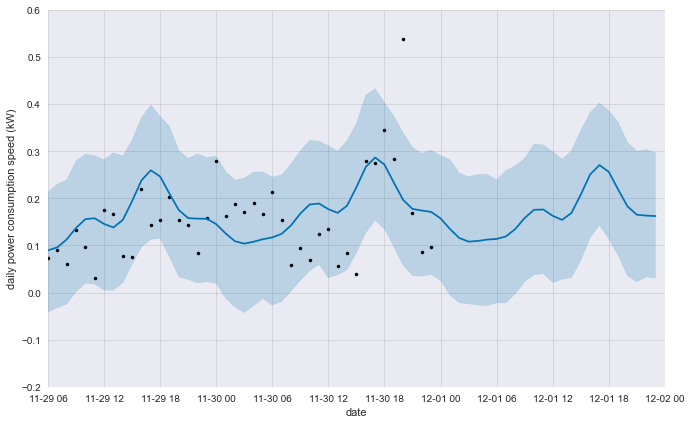

In [ ]:
#hide_input
_, ax = plt.subplots(1, 1)
ax.set_xlim([Timestamp('2017-11-29 06:00:00'), Timestamp('2017-12-02 00:00:00')])
ax.set_ylim([-0.2, 0.6])
mod['zeroHourFb'].plot(
    df_forecast, ax=ax, xlabel='date', ylabel='daily power consumption speed (kW)'
);

Out-of-sample forecasts for future 4 hours are:

In [ ]:
#hide_input
res = df_forecast.loc[2928:2931, ['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
res.set_index('ds', inplace=True)
res.index.name = 'datetime'
res

,yhat,yhat_lower,yhat_upper
datetime,,,
2017-12-01 00:00:00,0.157450,0.026090,0.290846
2017-12-01 01:00:00,0.135131,-0.005102,0.282784
2017-12-01 02:00:00,0.115922,-0.021668,0.253831
2017-12-01 03:00:00,0.108154,-0.024035,0.245774


### Multiple Seasonality

Here are plots for one trending and two seasonality components.

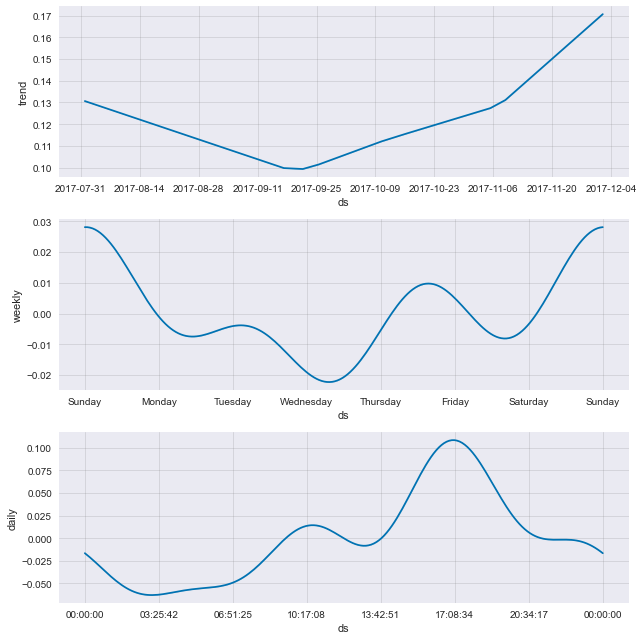

In [ ]:
#hide_input
mod['zeroHourFb'].plot_components(df_forecast);

Unfortunately, it is impossible to apply seasonal ARIMA, because of multiple seasonality.

### Specification Tests

The assumption that residuals from Prophet model is rejected.

In [ ]:
#hide
sms.jarque_bera(data['zeroHourFbResid']['resid'])[1] < 0.05

False

According to White's test for Heteroscedasticity, variance of residuals does vary with power consumptions.

In [ ]:
#hide
sms.het_white(
    data['zeroHourFbResidNaN0']['resid'],
    add_constant(data['zeroHourFbResidNaN0']['y'])
)[1] < 0.05

True

As suggested by the previous test, variance of residuals increases with respect to power consumptions. That is, when power consumption is high, the in-sample forcast is expected to have a high residual. The same goes for out-of-sample forecasts.

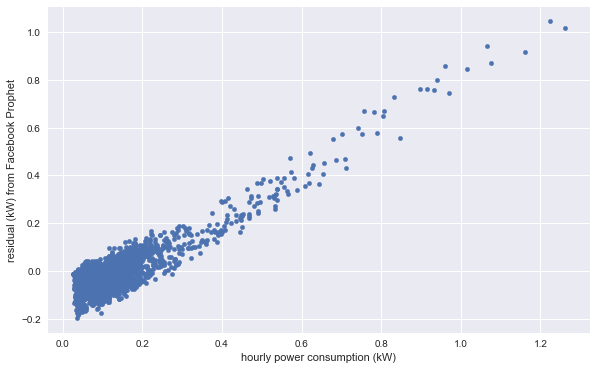

In [ ]:
#hide_input
ax = data['zeroHourFbResid'].plot(x='y', y='resid', kind='scatter');
ax.set_ylabel("residual (kW) from Facebook Prophet");
ax.set_xlabel("hourly power consumption (kW)");

In spite of the previous finding, when residuals are compared to corresponding values, they can be 4 times larger. So it is hard to say that more precise forecasts can be made when power consumption is low (usually during nights).

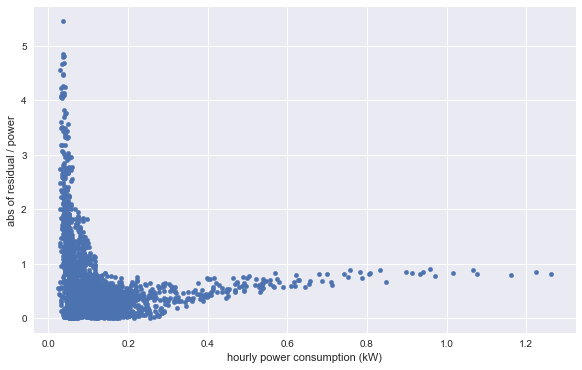

In [ ]:
#hide
data['zeroHourFbResid']['residAbsRelative'] = (
    data['zeroHourFbResid']['resid'].abs() /
    data['zeroHourFbResid']['y']
)

ax = data['zeroHourFbResid'].plot(x='y', y='residAbsRelative', kind='scatter');
ax.set_ylabel("abs of residual / power");
ax.set_xlabel("hourly power consumption (kW)");

### Autocorrelation Tests and ARIMA Model

All the Ljung-Box tests for lags 1, 2, 3, 4, 5, 24, and 168 reject the assumption that the residual is not correlated.

In [ ]:
#hide
[
    pvalue < 0.05
    for pvalue in sms.acorr_ljungbox(
        data['zeroHourFbResid']['resid'].fillna(0), lags=[1, 2, 3, 4, 5, 24, 168]
    )[1].tolist()
]

/Users/edxu96/Library/Caches/pypoetry/virtualenvs/elec-consumption-FzRBkitR-py3.7/lib/python3.7/site-packages/statsmodels/stats/diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


[True, True, True, True, True, True, True]

The test is supported by ACF. Missing values are dropped.

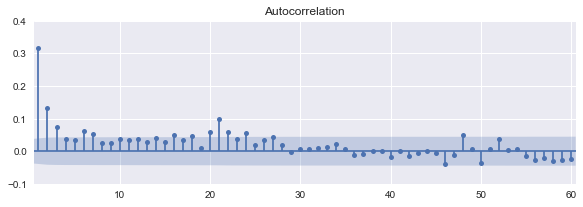

In [ ]:
#hide_input
_, ax = plt.subplots(1, 1, figsize=(3 * _golden_ratio * 2, 3))
plot_acf(data['zeroHourFbResid']['resid'].dropna(), lags=60, ax=ax);
ax.set_ylim([-0.1, 0.4]);
ax.set_xlim([0.5, 60.5]);

Such information can be modelled by a SARIMA with AR1, AR1 (24), MA1 (24).

In [ ]:
#hide
fit = ARIMA(
    endog=data['zeroHourFbResid']['resid'].fillna(0), order=(1, 0, 0),
    freq='H', seasonal_order=(1, 0, 1, 24), trend=None
).fit()

/Users/edxu96/Library/Caches/pypoetry/virtualenvs/elec-consumption-FzRBkitR-py3.7/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


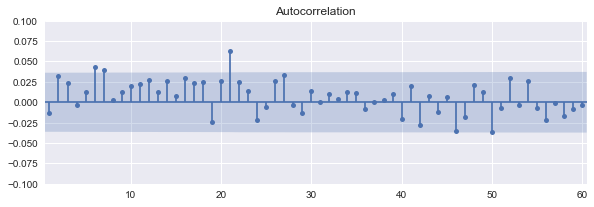

In [ ]:
#hide_input
_, ax = plt.subplots(1, 1, figsize=(3 * _golden_ratio * 2, 3))
plot_acf(fit.resid, lags=60, ax=ax);
ax.set_ylim([-0.1, 0.1]);
ax.set_xlim([0.5, 60.5]);

Independence assumptions in lags 1, 2, 3, 4, and 5 are not rejected, so the model has been improved.

In [ ]:
#hide
[
    pvalue < 0.05
    for pvalue in sms.acorr_ljungbox(fit.resid, lags=[1, 2, 3, 4, 5, 24, 168])[1].tolist()
]

/Users/edxu96/Library/Caches/pypoetry/virtualenvs/elec-consumption-FzRBkitR-py3.7/lib/python3.7/site-packages/statsmodels/stats/diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


[False, False, False, False, False, True, True]

The model is still not satisfying, because it does not pass normality test and heteroskedasticity test.

In [ ]:
#hide
# The constant term should be removed.
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              resid   No. Observations:                 2928
Model:             ARIMA(1, 0, 0)x(1, 0, [1], 24)   Log Likelihood                2740.060
Date:                            Fri, 18 Dec 2020   AIC                          -5470.119
Time:                                    07:46:30   BIC                          -5440.209
Sample:                                08-01-2017   HQIC                         -5459.347
                                     - 11-30-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.445e-05      0.009      0.005      0.996      -0.017       0.017
ar.L1          0.3254      0.008     40.291      0.000       0.310       0.341
ar.S.L24       0.9902      0.004    236.527      0.000       0.982       0.998
ma.S.L24      -0.9677      0.008   -119.830      0.000      -0.984      -0.952
sigma2         0.0090   7.72e-05    116.406      0.000       0.009       0.009
===================================================================================
Ljung-Box (L1) (Q):                   0.52   Jarque-Bera (JB):            117272.85
Prob(Q):                              0.47   Prob(JB):                         0.00
Heteroskedasticity (H):               1.77   Skew:                             4.07
Prob(H) (two-sided):                  0.00   Kurtosis:                        32.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## 4. Result